# Chapter 12: The Forest Fires case study

In [1]:
import pandas as pd
import seaborn as sns

## Get the data

### Download zip file to disk

In [2]:
# Note: This may take a long time to run
fires_url = 'https://www.fs.usda.gov/rds/archive/products/RDS-2013-0009.4/'
filename = 'RDS-2013-0009.4_SQLITE.zip'
from urllib import request
request.urlretrieve(fires_url+filename, filename=filename)

('RDS-2013-0009.4_SQLITE.zip', <http.client.HTTPMessage at 0x18f60ea0220>)

### Unzip and print file info

In [3]:
from zipfile import ZipFile

with ZipFile('RDS-2013-0009.4_SQLITE.zip', mode='r') as zip:
    zip.extractall()        
    for file in zip.infolist():    
        print(file.filename, file.compress_size, file.file_size)

Data/FPA_FOD_20170508.sqlite 173776108 795785216
Data/ 0 0
_metadata_RDS-2013-0009.4.xml 11571 51400
Supplements/FPA_FOD_Source_List.pdf 74137 109336
Supplements/ 0 0
_fileindex_RDS-2013-0009.4.html 1098 4398
_metadata_RDS-2013-0009.4.html 13296 89005


### Connect to SQLite database and create a cursor

In [4]:
import sqlite3
fires_con = sqlite3.connect('Data/FPA_FOD_20170508.sqlite')
fires_cur = fires_con.cursor()
type(fires_con)

sqlite3.Connection

### Check out the tables and columns

In [5]:
fires_cur.execute(
    'SELECT name FROM sqlite_master WHERE type="table"').fetchall()

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

In [6]:
fires_cur.execute('PRAGMA table_info(Fires)').fetchall()

[(0, 'OBJECTID', 'integer', 1, None, 1),
 (1, 'FOD_ID', 'int32', 0, None, 0),
 (2, 'FPA_ID', 'text(100)', 0, None, 0),
 (3, 'SOURCE_SYSTEM_TYPE', 'text(255)', 0, None, 0),
 (4, 'SOURCE_SYSTEM', 'text(30)', 0, None, 0),
 (5, 'NWCG_REPORTING_AGENCY', 'text(255)', 0, None, 0),
 (6, 'NWCG_REPORTING_UNIT_ID', 'text(255)', 0, None, 0),
 (7, 'NWCG_REPORTING_UNIT_NAME', 'text(255)', 0, None, 0),
 (8, 'SOURCE_REPORTING_UNIT', 'text(30)', 0, None, 0),
 (9, 'SOURCE_REPORTING_UNIT_NAME', 'text(255)', 0, None, 0),
 (10, 'LOCAL_FIRE_REPORT_ID', 'text(255)', 0, None, 0),
 (11, 'LOCAL_INCIDENT_ID', 'text(255)', 0, None, 0),
 (12, 'FIRE_CODE', 'text(10)', 0, None, 0),
 (13, 'FIRE_NAME', 'text(255)', 0, None, 0),
 (14, 'ICS_209_INCIDENT_NUMBER', 'text(255)', 0, None, 0),
 (15, 'ICS_209_NAME', 'text(255)', 0, None, 0),
 (16, 'MTBS_ID', 'text(255)', 0, None, 0),
 (17, 'MTBS_FIRE_NAME', 'text(50)', 0, None, 0),
 (18, 'COMPLEX_NAME', 'text(255)', 0, None, 0),
 (19, 'FIRE_YEAR', 'int16', 0, None, 0),
 (20, '

### Import the data into a DataFrame

In [7]:
# NOTE: This may take a long time to run
fires_sql = """
            SELECT fire_name, fire_size,
                state, latitude, longitude,
                fire_year, 
                DATETIME(discovery_date) AS discovery_date,
                DATETIME(cont_date) AS contain_date
            FROM Fires
            """
fires = pd.read_sql_query(fires_sql, fires_con)
fires.head(3)

,FIRE_NAME,FIRE_SIZE,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,discovery_date,contain_date
0,FOUNTAIN,0.10,CA,40.036944,-121.005833,2005,2005-02-02 00:00:00,2005-02-02 00:00:00
1,PIGEON,0.25,CA,38.933056,-120.404444,2004,2004-05-12 00:00:00,2004-05-12 00:00:00
2,SLACK,0.10,CA,38.984167,-120.735556,2004,2004-05-31 00:00:00,2004-05-31 00:00:00


### Save and retrieve DataFrame

In [8]:
fires.to_pickle('fires_raw.pkl')

In [9]:
%time fires = pd.read_pickle('fires_raw.pkl')

Wall time: 1.62 s


## Clean the data

### Examine data

In [10]:
fires.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   FIRE_NAME       object 
 1   FIRE_SIZE       float64
 2   STATE           object 
 3   LATITUDE        float64
 4   LONGITUDE       float64
 5   FIRE_YEAR       int64  
 6   discovery_date  object 
 7   contain_date    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 473.8 MB


In [11]:
fires.describe().T

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE,1880465.0,74.520158,2497.598180,0.000010,0.10000,1.000000,3.3000,606945.000000
LATITUDE,1880465.0,36.781213,6.139031,17.939722,32.81860,35.452500,40.8272,70.330600
LONGITUDE,1880465.0,-95.704942,16.716944,-178.802600,-110.36347,-92.043043,-82.2976,-65.256944
FIRE_YEAR,1880465.0,2003.709974,6.663099,1992.000000,1998.00000,2004.000000,2009.0000,2015.000000


### Improve the readability

In [12]:
fires.columns = fires.columns.str.lower()
fires.head(3)

,fire_name,fire_size,state,latitude,longitude,fire_year,discovery_date,contain_date
0,FOUNTAIN,0.10,CA,40.036944,-121.005833,2005,2005-02-02 00:00:00,2005-02-02 00:00:00
1,PIGEON,0.25,CA,38.933056,-120.404444,2004,2004-05-12 00:00:00,2004-05-12 00:00:00
2,SLACK,0.10,CA,38.984167,-120.735556,2004,2004-05-31 00:00:00,2004-05-31 00:00:00


In [13]:
fires.rename(columns={'fire_size':'acres_burned'},inplace=True)

In [14]:
fires['fire_name'] = fires.fire_name.str.title()

### Drop unnecessary rows

In [15]:
fires = fires[fires.acres_burned >= 10]

In [16]:
fires.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274170 entries, 16 to 1880441
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fire_name       128667 non-null  object 
 1   acres_burned    274170 non-null  float64
 2   state           274170 non-null  object 
 3   latitude        274170 non-null  float64
 4   longitude       274170 non-null  float64
 5   fire_year       274170 non-null  int64  
 6   discovery_date  274170 non-null  object 
 7   contain_date    137377 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 70.6 MB


### Drop duplicate rows

In [17]:
fires[fires.duplicated(keep=False)]

,fire_name,acres_burned,state,latitude,longitude,fire_year,discovery_date,contain_date
1350848,None,14.0,NY,42.223532,-73.687350,1997,1997-02-26 00:00:00,None
1350859,None,14.0,NY,42.223532,-73.687350,1997,1997-02-26 00:00:00,None
1371586,None,15.0,CT,41.279541,-72.815099,2000,2000-03-06 00:00:00,None
1371587,None,15.0,CT,41.279541,-72.815099,2000,2000-03-06 00:00:00,None
1432190,None,30.0,AL,32.640810,-86.837740,1995,1995-07-20 00:00:00,None
...,...,...,...,...,...,...,...,...
1721251,None,10.0,PR,18.057226,-66.406883,2011,2011-04-01 00:00:00,None
1843668,None,12.0,MA,42.201056,-72.640495,2015,2015-05-15 00:00:00,2015-05-15 00:00:00
1843669,None,12.0,MA,42.201056,-72.640495,2015,2015-05-15 00:00:00,2015-05-15 00:00:00
1861585,None,10.0,HI,21.497620,-158.187042,1992,1992-09-07 00:00:00,None


In [18]:
fires = fires.drop_duplicates(keep='first')

In [19]:
fires.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274123 entries, 16 to 1880441
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fire_name       128667 non-null  object 
 1   acres_burned    274123 non-null  float64
 2   state           274123 non-null  object 
 3   latitude        274123 non-null  float64
 4   longitude       274123 non-null  float64
 5   fire_year       274123 non-null  int64  
 6   discovery_date  274123 non-null  object 
 7   contain_date    137376 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 70.6 MB


### Convert dates to datetimes

In [20]:
fires.discovery_date = \
    pd.to_datetime(fires.discovery_date, infer_datetime_format=True)

In [21]:
fires.contain_date = \
    pd.to_datetime(fires.contain_date, infer_datetime_format=True)

### Check for missing contain dates

In [22]:
fires[fires.contain_date.isnull()]

,fire_name,acres_burned,state,latitude,longitude,fire_year,discovery_date,contain_date
1566,Seven Springs,85.00,MO,36.992500,-92.186111,2005,2005-03-17,NaT
5095,Peppin,64488.00,NM,33.601389,-105.433333,2004,2004-05-15,NaT
5740,Rochelle Hills,230.00,WY,43.571667,-105.085833,2005,2005-08-26,NaT
8187,Knife,560.00,AZ,35.132778,-111.399444,2006,2006-05-27,NaT
10883,Grant,190.00,AZ,33.626111,-109.248889,2006,2006-07-19,NaT
...,...,...,...,...,...,...,...,...
1880206,Ranchita,24.20,CA,35.805000,-120.575000,2010,2010-06-21,NaT
1880316,None,24.74,CA,35.271667,-118.617967,2013,2013-05-25,NaT
1880352,San Marcos,70.00,CA,38.020433,-121.982883,2010,2010-08-23,NaT
1880419,Slaughterhouse,50.00,CA,32.906591,-116.942448,2010,2010-05-29,NaT


In [23]:
fires.query('contain_date != contain_date & acres_burned >= 10000') \
    .sort_values('acres_burned', ascending=False)

,fire_name,acres_burned,state,latitude,longitude,fire_year,discovery_date,contain_date
1639394,Silver,234000.0,NM,32.888889,-107.809722,2013,2013-06-07,NaT
654163,Glass,220000.0,TX,31.742160,-101.043800,2008,2008-02-25,NaT
377944,Camp Creek,175815.0,AK,64.333340,-145.166700,2004,2004-06-23,NaT
512403,Pine Ridge Complex,121687.0,MT,45.922800,-107.856100,2006,2006-07-12,NaT
350860,Moose Lake,117920.0,AK,63.591100,-152.675700,2002,2002-07-17,NaT
...,...,...,...,...,...,...,...,...
1552706,Miller Ranch,10000.0,TX,32.626600,-101.680012,2011,2011-03-24,NaT
1455520,East Fork,10000.0,ID,45.845556,-115.030000,2011,2011-08-10,NaT
801533,None,10000.0,KY,37.474200,-82.995600,1999,1999-11-08,NaT
723084,Farley,10000.0,NM,36.239445,-104.142776,1996,1996-02-26,NaT


In [24]:
fires.query('contain_date != "NaT" & acres_burned >= 100') \
    .sort_values('acres_burned', ascending=False)

,fire_name,acres_burned,state,latitude,longitude,fire_year,discovery_date,contain_date
211296,Inowak,606945.0,AK,61.982700,-157.085700,1997,1997-06-25,1997-09-09
1579574,Long Draw,558198.3,OR,42.391894,-117.893687,2012,2012-07-08,2012-07-30
1459664,Wallow,538049.0,AZ,33.606111,-109.449722,2011,2011-05-29,2011-07-12
305585,Boundary,537627.0,AK,65.266300,-146.885800,2004,2004-06-13,2004-09-30
1215267,Minto Flats South,517078.0,AK,64.746700,-149.504700,2009,2009-06-21,2009-09-11
...,...,...,...,...,...,...,...,...
241980,Terrill,100.0,MO,37.444010,-91.462270,1994,1994-04-17,1994-04-17
1564630,Goat,100.0,ID,45.977500,-114.878889,2012,2012-07-28,2012-10-25
241154,Easter 2,100.0,AR,36.108440,-92.439630,1994,1994-04-02,1994-04-03
240472,Moore #1,100.0,TX,35.632500,-101.683900,1997,1997-03-06,1997-03-06


### Save and retrieve DataFrame

In [25]:
fires.to_pickle('fires_clean.pkl')

In [26]:
fires = pd.read_pickle('fires_clean.pkl')

## Prepare data

In [27]:
fires['fire_month'] = fires.discovery_date.dt.month

In [28]:
fires['days_burning'] = (fires.contain_date - fires.discovery_date).dt.days

In [29]:
fires.days_burning.describe()

count    137376.000000
mean          3.254520
std          16.052833
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        1881.000000
Name: days_burning, dtype: float64

In [30]:
fires.query('acres_burned >= 100')[['fire_name','acres_burned',
    'discovery_date','contain_date','days_burning']] \
    .sort_values('days_burning', ascending=False)

,fire_name,acres_burned,discovery_date,contain_date,days_burning
356156,Buenavista,120.0,2000-08-07,2005-10-01,1881.0
305237,Kiliovilik,100.0,2001-06-11,2004-06-16,1101.0
357487,Road 09-08 Wf,900.0,2006-03-05,2008-03-09,735.0
1324066,Jims Branch,158.0,1994-11-05,1996-11-06,732.0
1227849,30305,250.0,2003-03-25,2005-03-25,731.0
...,...,...,...,...,...
1879328,None,149.0,2013-05-28,NaT,NaN
1879498,Trabing,630.0,2008-06-20,NaT,NaN
1879564,Forty Nine,311.0,2009-08-30,NaT,NaN
1879892,Red,134.0,2015-06-21,NaT,NaN


In [31]:
fires.to_pickle('fires_prepared.pkl')

In [32]:
fires = pd.read_pickle('fires_prepared.pkl')

## Analyze the data

### Analyze the data for California

In [33]:
fires.query('state == "CA"')[['acres_burned','days_burning']].describe().T

,count,mean,std,min,25%,50%,75%,max
acres_burned,14299.0,881.934274,7342.398281,10.0,15.0,39.0,135.0,315578.8
days_burning,6733.0,5.387197,28.591571,0.0,0.0,1.0,3.0,1881.0


<AxesSubplot:title={'center':'Largest Fire in California by Year'}, xlabel='fire_year', ylabel='acres_burned'>

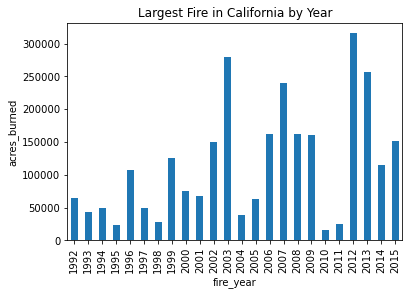

In [34]:
fires.query('state == "CA"') \
    .groupby('fire_year').acres_burned.max() \
    .plot.bar(ylabel='acres_burned', 
              title='Largest Fire in California by Year')

<AxesSubplot:title={'center':'Mean and Median Fires Sizes in California by Year'}, xlabel='fire_year'>

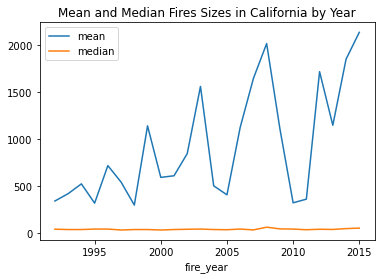

In [35]:
fires.query('state == "CA"') \
    .groupby('fire_year').acres_burned.agg(['mean','median']) \
    .plot(title='Mean and Median Fires Sizes in California by Year')

<AxesSubplot:title={'center':'Number of Fires by Month in California'}, xlabel='fire_month'>

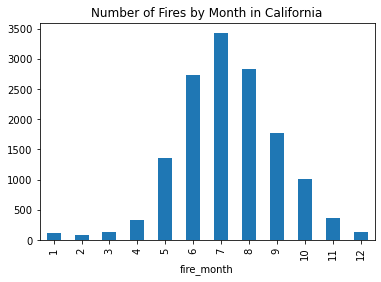

In [36]:
fires.query('state == "CA"') \
    .groupby('fire_month').acres_burned.count() \
    .plot.bar(title='Number of Fires by Month in California')

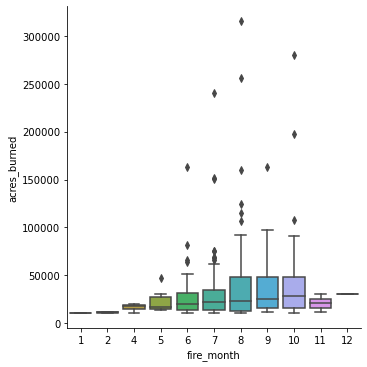

In [37]:
sns.catplot(data=fires.query('state == "CA" & acres_burned >= 10000'),
            kind='box', x='fire_month', y='acres_burned')

### Rank the states by total acres burned

In [38]:
fires_states = fires.groupby('state').acres_burned.sum().to_frame()

In [39]:
fires_states['state_rank'] = \
    fires_states['acres_burned'].rank(ascending=False)
fires_states.sort_values('state_rank', inplace=True)
fires_states.head()

,acres_burned,state_rank
state,,
AK,3.222601e+07,1.0
ID,1.366231e+07,2.0
CA,1.261078e+07,3.0
TX,9.588463e+06,4.0
NV,9.006310e+06,5.0


<AxesSubplot:title={'center':'Total Acres Burned in the Top 10 States'}, xlabel='state', ylabel='ten millions of acreas'>

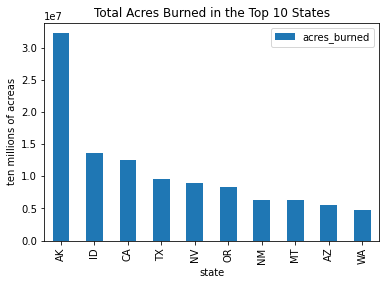

In [40]:
fires_states.query('state_rank <= 10') \
    .plot.bar(y='acres_burned', ylabel='ten millions of acreas',
              title='Total Acres Burned in the Top 10 States')

### Prepare a DataFrame for acres burned by year and state

In [41]:
fires_states_years = \
    fires.groupby(['state','fire_year']).acres_burned.sum().to_frame()
fires_states_years.head(4)

acres_burned
state fire_year              
AK    1992           142444.7
      1993           686630.5
      1994           261604.7
      1995            43762.6

In [42]:
fires_states_years = fires_states_years.join(fires_states, 
    lsuffix='_by_year', rsuffix='_total')
fires_states_years.head(4)

acres_burned_by_year  acres_burned_total  state_rank
state fire_year                                                      
AK    1992                   142444.7        3.222601e+07         1.0
      1993                   686630.5        3.222601e+07         1.0
      1994                   261604.7        3.222601e+07         1.0
      1995                    43762.6        3.222601e+07         1.0

In [43]:
fires_states_top4 = fires_states_years.query('state_rank <= 4')
fires_states_top4 = fires_states_top4.reset_index()
fires_states_top4.head(4)

,state,fire_year,acres_burned_by_year,acres_burned_total,state_rank
0,AK,1992,142444.7,3.222601e+07,1.0
1,AK,1993,686630.5,3.222601e+07,1.0
2,AK,1994,261604.7,3.222601e+07,1.0
3,AK,1995,43762.6,3.222601e+07,1.0


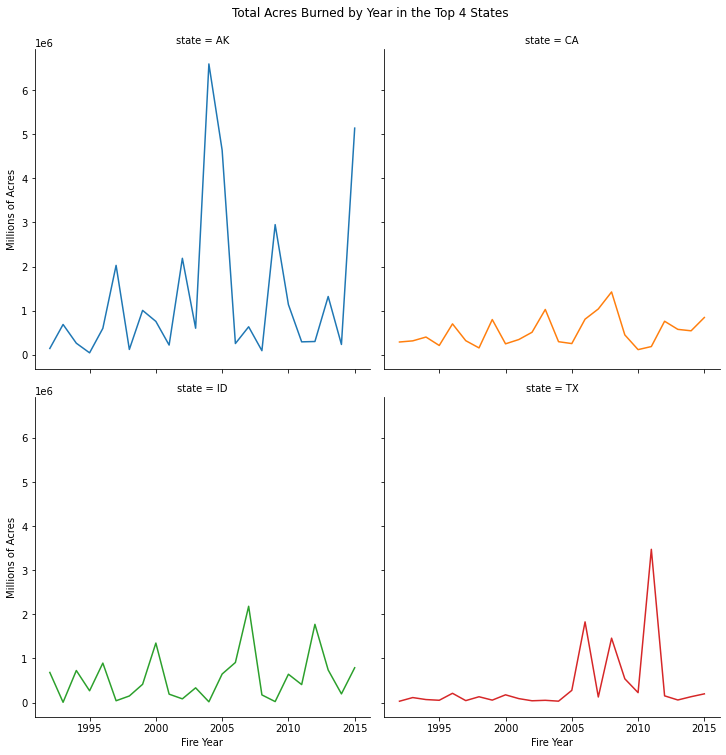

In [44]:
g = sns.relplot(data=fires_states_top4, kind='line', 
    x='fire_year', y='acres_burned_by_year', hue='state',
    col='state', col_wrap=2, legend=False)

g.fig.suptitle('Total Acres Burned by Year in the Top 4 States', y=1.025)
for ax in g.axes.flat: 
    ax.set_xlabel('Fire Year')
    ax.set_ylabel('Millions of Acres')

## Visualize data

### Review the top 20 fires in California

In [45]:
top_fires = fires.query('state == "CA"').nlargest(20, columns='acres_burned')
top_fires[['fire_year','fire_name','acres_burned','days_burning']].head(10)

,fire_year,fire_name,acres_burned,days_burning
1572842,2012,Rush,315578.8,71.0
163770,2003,Cedar,280059.0,10.0
1641750,2013,Rim,255858.0,68.0
24834,2007,Zaca,240207.0,60.0
26363,2007,Witch,197990.0,10.0
27901,2008,Basin Complex,162818.0,36.0
14835,2006,Day,162702.0,56.0
41296,2009,Station,160371.0,27.0
1793232,2015,Rough,151623.0,98.0
152416,2002,Mcnally,150696.0,38.0


<AxesSubplot:xlabel='fire_year'>

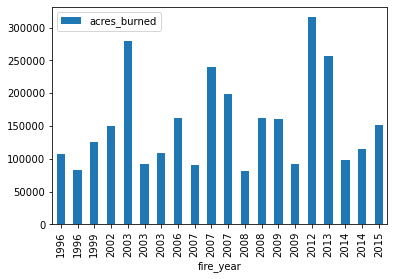

In [46]:
top_fires.sort_values('fire_year').plot.bar(x='fire_year', y='acres_burned')

## Use Geopandas to plot the fires on a California map

In [47]:
fires_CA_2015 = fires.query('fire_year == 2015 & state == "CA"')

In [48]:
import geopandas as geo
# Create GeoDataFrame from DataFrame
fire_locations = geo.GeoDataFrame(fires_CA_2015, 
    geometry=geo.points_from_xy(fires_CA_2015.longitude, fires_CA_2015.latitude))

In [49]:
usa = geo.read_file('Maps/states.shp')
usa.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


<AxesSubplot:>

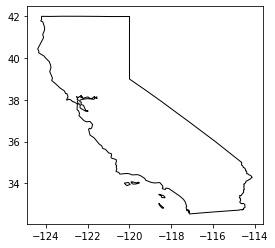

In [50]:
# The map for CA
ca_map = usa[usa.STATE_ABBR == 'CA']
ca_map.plot(color='white', edgecolor='black')

<AxesSubplot:>

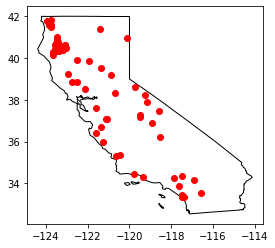

In [51]:
fire_locations.query('acres_burned > 500').plot(color='red',
    ax=ca_map.plot(color='white', edgecolor='black'))

[Text(0.5, 1.0, 'California fires in 2015 over 500 acres'),
 Text(79.73068341007834, 0.5, ''),
 Text(0.5, 15.0, '')]

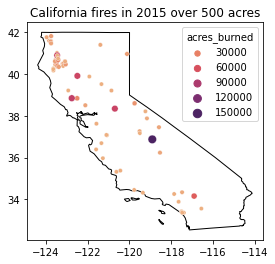

In [52]:
ca_map = usa[usa.STATE_ABBR == 'CA']
ca_map.plot(color='white', edgecolor='black')
ax = sns.scatterplot(data=fires_CA_2015.query('acres_burned > 500'),
    x='longitude', y='latitude', size='acres_burned', hue='acres_burned', palette='flare')
ax.set(title='California fires in 2015 over 500 acres',
       ylabel=None, xlabel=None)

[Text(0.5, 1.0, 'Continental U.S. fires over 100,000 acres'),
 Text(97.52857630079816, 0.5, ''),
 Text(0.5, 24.0, '')]

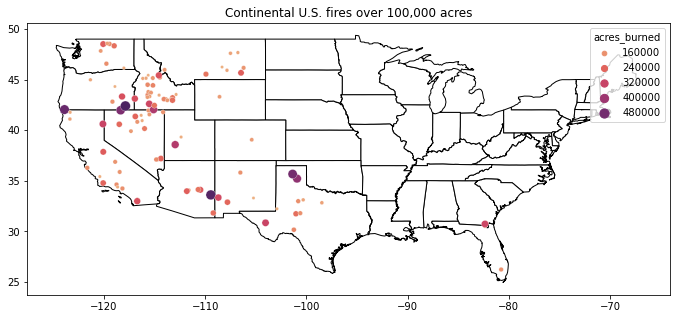

In [53]:
continental_usa = usa.loc[1:49]
continental_usa.plot(color='white', edgecolor='black', figsize=(12,5))
ax = sns.scatterplot(
    data=fires.query('acres_burned > 100_000 & state not in ["AK","HI"]'),
    x='longitude', y='latitude', size='acres_burned', sizes=(10,100),
    hue='acres_burned', palette='flare')

ax.set(title='Continental U.S. fires over 100,000 acres', 
       ylabel=None, xlabel=None)

In [54]:
ax.get_figure().savefig('us_fires_map.png')